## Using LSTM to Predict Apple Stock Price - Same random seed x 3 

<p> Date: 2026-11-7 &emsp;&emsp;&emsp;
<br><br> 

**Content:** <br>
- [Background](#background)

- [Jump to Experiemnt 🧪⚗️ ](#experiment)

    - [Modeling](#modeling)

    - [Prediction](#prediction)

- [Reference] 

## Background

### Stock Analysis using Neural Networks (NNs) 

There are several types of NN/time‐series frameworks that are freely available, along with how they might map to stock‐price forecasting.

1. Recurrent Neural Networks (RNNs) – especially LSTM/GRU
    - `LSTM = Long Short-Term Memory`; GRU = Gated Recurrent Units  
    - The classic approach: use a sequence of past price (and optionally volume/indicators) to forecast next price or return. e.g., using TensorFlow / Keras you can build a straightforward LSTM model. 
    - Example: Using x_train of shape (time_steps, features) and LSTM layers, return_sequences, etc. 
    - Also GRU variants (Gated Recurrent Units) appear in literature. 

2. Hybrid CNN-LSTM / Attention models: 
    - The combine convolutional layers (extracting features) + LSTM (temporal modelling) + even boosting/regression at the end. For example: “Attention-based CNN-LSTM and XGBoost hybrid model” for stock prediction. 
    - This aligns with your advanced modelling skills (you’ve done PCA/DOE etc) — you could extract high‐level features via a CNN/attention block, then feed into an LSTM.
    - When useful: If you believe there are patterns (e.g., in price/volume “shapes”) that go beyond a simple sequence of numeric features, or if you want to incorporate other modalities (e.g., sentiment, technical indicators).

3. Feed‐forward Neural Networks (FFNN) / Multi‐Layer Perceptrons
    - Simpler: treat features (past N days of OHLCV, technical indicators) → dense network → predict price/return. Some works show metaheuristic optimisation (e.g., genetic algorithms) for FFNN weights. 
    - When useful: If you have engineered good features (your specialty) and you believe a static “window → target” model is viable.

4. Reinforcement Learning / Deep RL libraries for trading
    - While not exactly “predicting the next price”, these libraries treat the problem as: decide to buy/sell/hold based on state, using neural‐net policies. Example: FinRL is open source and designed for automated finance tasks. 
    - When useful: If you’re interested not only in forecasting, but in building a strategy that uses predictions (or features) plus actions.

### 2. Practical Application Guide 

1. **`LSTM`**/GRU with Keras/TensorFlow: e.g., use past N days [Close, Volume, maybe indicators] → predict next day close or return. Use tutorial from Alpha Vantage.

2. CNN‐LSTM hybrid: use 1-D convolution (over time) to extract features, followed by LSTM (or stack) for temporal modelling. Use the referenced research as blueprint.

3. FFNN (dense) on engineered features: you engineer features (moving averages, RSI, PCA of price/volume), feed into a MLP.

4. AutoML/hyperparameter tuning: use Microsoft NNI (or other open‐source tools) to automate architecture/hyperparameter experiments.

5. Deep RL for trading decision: if you extend from pure forecasting to decision‐making, then use FinRL or similar to build policy networks.

## Experiment


In [ ]:
# ##### ===== System Setup ==== ##### 
# uncomment the code below for a more automatic folder and log function 

# %load_ext dotenv
# %dotenv

# import os, sys
# from utils.logger import get_logger
# from datetime import datetime

# _logs = get_logger(__name__)
# _logs.info(f"Hello World! Today is {datetime.now().strftime('%A, %B %d, %Y')}")

# # sys.path.append(os.getenv('SRC_DIR'))

In [1]:
##### >>> 1: Testing with APPL(Apple)

### >> 1.1 Load Libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler


2025-11-10 13:46:02.764966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-10 13:46:02.780375: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-10 13:46:02.785190: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-10 13:46:02.796670: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-10 13:46:03.398599: W tensorflow/compiler/tf2

In [2]:
### >> 1.2 Load the price data, AAPL 
FILE_PATH = "../05_src/data/raw"
RAW_FILE = os.path.join(FILE_PATH, "prices-split-adjusted.csv")

Tick = 'AAPL'

df = pd.read_csv(RAW_FILE, parse_dates=["date"])
df = df.groupby('symbol').filter(lambda x: len(x) > 1500) # make all the data is in the same length

# check for NaN or Null 
print(df.isnull().sum())
print(f"Any NA: {df.isna().any().any()}")  # False

print(f"Ticker: {Tick}")
print(f"Data Exist: {Tick in df['symbol'].unique() }")

df = df[df["symbol"] == Tick].sort_values("date")  # Example: AAPL
df = df[["date", "close"]].set_index("date")
print(f"Number of record: {len(df)}")
df.tail()

date      0
symbol    0
open      0
close     0
low       0
high      0
volume    0
dtype: int64
Any NA: False
Ticker: AAPL
Data Exist: True
Number of record: 1762


,close
date,
2016-12-23,116.519997
2016-12-27,117.260002
2016-12-28,116.760002
2016-12-29,116.730003
2016-12-30,115.820000


#### Modeling - **Key Concept**

1. **`create_dataset`**:

    - series[i:i+look_back]: takes a window of look_back consecutive days as input.  

    - series[i+look_back]: the next day after the window is the target.  

    | Input window (`X`) | Target (`y`) |
    | ------------------ | ------------ |
    | day 0–19           | day 20       |
    | day 1–20           | day 21       |
    | day 2–21           | day 22       |
    | …                  | …            |

    For a series of length 100, the number of (X, y) pairs is: 

    <p style="text-align:left;"><em>&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;100 - 20 = 80</em></p>

    So you end up with 80 rows of training data

2. `model.fit()`: set shuffle = False as this is time series 

3. 

```text
            ┌────────────────────────────────────┐
            │           Input Layer              │
            │     (20 timesteps × 1 feature)     │
            └──────────────────┬─────────────────┘
                               │
                               ▼
            ┌────────────────────────────────────┐
            │            LSTM Layer              │
            │  50 hidden units  (~10,400 params) │
            │  Learns temporal dependencies      │
            └──────────────────┬─────────────────┘
                               │
                               ▼
            ┌────────────────────────────────────┐
            │           Dense Output             │
            │         (1 neuron output)          │
            │   Predicts next-day price value    │
            └────────────────────────────────────┘
  




In [3]:
##### >>> 2. LSTM Model Construction 
# Scale data
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df)

# define a helper fucntion to create a supervised data as input sequence (the sliding window and look_back = 20)
def create_dataset(series, look_back):  
    X, y = [], []
    for i in range(len(series) - look_back):
        X.append(series[i:i+look_back])
        y.append(series[i+look_back])
    return np.array(X), np.array(y)


# create train, test data for both x and y
X, y = create_dataset(scaled, 20)  # <- set look_back = 20 days
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# split for validation
split_val = int(len(X_train)*0.2) # 20% of last training data for validation
X_train_sub, X_val = X_train[:-split_val], X_train[-split_val:]
y_train_sub, y_val = y_train[:-split_val], y_train[-split_val:]

print(X_train.shape)
print(y_train.shape)

(1393, 20, 1)
(1393, 1)


In [4]:
### >> 2.2 Create a helper function

def create_lstm_model(input_shape):
    model = Sequential([
        tf.keras.Input(shape=input_shape),
        LSTM(50, activation='tanh'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

#### **LSTM expects input in 3D shape**

| Dimension| Symbol             | Example value | Meaning                                                           |
| ---------| ------------------ | ------------- | ----------------------------------------------------------------- |
| 1        | `X_train.shape[0]` | e.g. 3000     | Number of sequences (samples) you created from your data          |
| 2        | `X_train.shape[1]` | e.g. 60       | Number of **time steps** in each sequence (the “lookback window”) |
| 3        | `X_train.shape[2]` | e.g. 1        | Number of **features per time step** (columns in your input)      |


Another way to think about is:
1. Time step ([1]): How many past days the model looks back? 
2. Feature per time step ([2]):	How many variables per day? only close or open, close,? 


#### Different Metrics Guide

| Metric                                    | Penalizes Large Errors? |  Scale-Dependent? |          Robust to Outliers?          | Gradient Behavior                                                                              | Common Use / Strength                                                           | Drawbacks                                                   | Best For                                                                   |
| :---------------------------------------- | :---------------------: | :---------------: | :-----------------------------------: | :--------------------------------------------------------------------------------------------- | :------------------------------------------------------------------------------ | :---------------------------------------------------------- | :------------------------------------------------------------------------- |
| **MSE** (Mean Squared Error)              |        ✅ Strongly       |       ✅ Yes       |                  ❌ No                 | ✅ Smooth, differentiable everywhere; larger gradients for bigger errors → good for neural nets | Emphasizes large mistakes; useful in training models (esp. NN/gradient descent) | Harder to interpret (units²); overly influenced by outliers | Optimizing NN models or when you want to heavily penalize large deviations |
| **RMSE** (Root Mean Squared Error)        |       ✅ Moderately      |       ✅ Yes       |                  ❌ No                 | ✅ Smooth (same as MSE, just transformed)                                                       | Same benefits as MSE but interpretable (same units as target)                   | Still sensitive to large errors                             | Reporting model accuracy in stock price units                              |
| **MAE** (Mean Absolute Error)             |         ❌ Linear        |       ✅ Yes       |                 ✅ Yes                 | ⚠️ Constant gradient almost everywhere, not smooth at zero → slower NN convergence             | Stable metric; simple to explain (“avg error = $X”)                             | Slower training in NN; doesn’t highlight big mistakes       | Evaluating performance robustly or for non-NN models                       |
| **MAPE** (Mean Absolute Percentage Error) |         ❌ Linear        | ❌ No (unitless %) | ❌ No (unstable for small true values) | ⚠️ Non-smooth due to division by target                                                        | Easy to interpret as percentage error; good for cross-stock comparison          | Undefined/unstable if price ≈ 0; biased toward low values   | Comparing models across stocks with different price ranges                 |



In [25]:
##### >>> 3.1 Train LSTM : same raddome seed x 3 to see if the model stable >> consistency result 
from tqdm import tqdm

metrics=[]
histories=[]
predictions=[]
seeds=[111,111,111]

for i in tqdm(range(3)): 
    random.seed(seeds[i])
    np.random.seed(seeds[i])
    tf.random.set_seed(seeds[i])
    # Train
    n_steps = X_train.shape[1]; n_features = X_train.shape[2]
    model_lstm = create_lstm_model((n_steps,n_features))
    
    history = model_lstm.fit(X_train_sub, y_train_sub, validation_data=(X_val, y_val), 
                             shuffle=False, epochs=20, batch_size=16, verbose=0) # time series, need to set shuffer = False
    histories.append(history)

    # Predict
    y_pred = model_lstm.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()   
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
    residuals = y_test_inv - y_pred_inv
    # reshape(-1,1): makes it 2D so the scaler can inverse-transform it.
    #.flatten():brings it back to 1D for easy subtraction or plotting afterward.
    
    # Save individual run results
    predictions.append({
        "Run": i+1,
        "Seed": seeds[i],
        "y_test": y_test_inv.copy(),
        "y_pred": y_pred_inv.copy()
    })

    # Metrics
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs(residuals / y_test_inv)) * 100
    # Compute directional accuracy
    # np.diff calculates day-to-day changes
    # np.sign gets the direction (+1 up, -1 down)
    direction_match = np.sign(np.diff(y_pred_inv, axis=0)) == np.sign(np.diff(y_test_inv, axis=0))
    direction_accuracy = np.mean(direction_match) * 100  # convert to percentage

    # --- Save results for comparison ---
    metrics.append({
        "Ticker": Tick,
        "Run": run,
        "MSE": mse,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "DirAcc (%)": direction_accuracy
    })

results_metrics_df = pd.DataFrame(metrics)

print(results_metrics_df.to_string(index=False, float_format="%.4f"))


  0%|          | 0/3 [00:00<?, ?it/s]

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 33%|███▎      | 1/3 [00:07<00:14,  7.42s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


 67%|██████▋   | 2/3 [00:14<00:07,  7.35s/it]

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


100%|██████████| 3/3 [00:22<00:00,  7.35s/it]

Ticker  Run    MSE   RMSE    MAE   MAPE  DirAcc (%)
  AAPL    2 5.1384 2.2668 1.6913 1.5924     48.8506
  AAPL    2 5.1384 2.2668 1.6913 1.5924     48.8506
  AAPL    2 5.1384 2.2668 1.6913 1.5924     48.8506


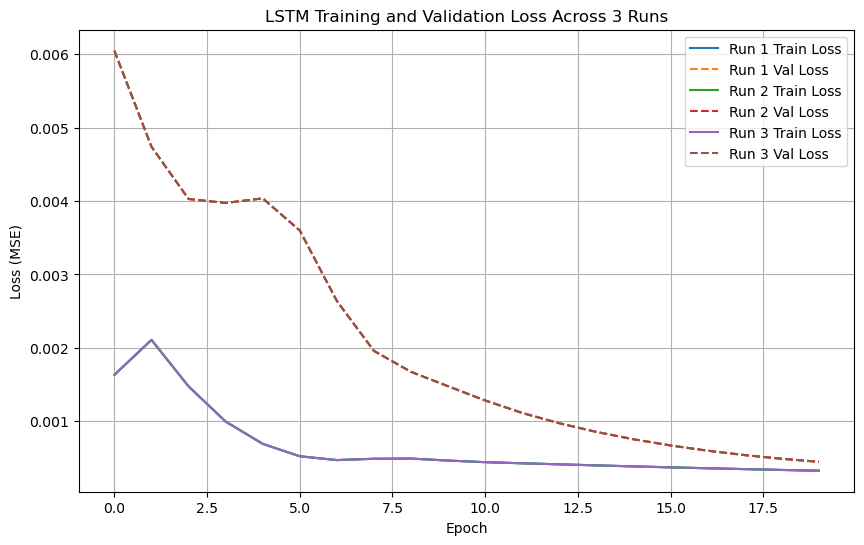

In [10]:
## >> training plot: same seed x 3

plt.figure(figsize=(10,6))
for run in range(3):
    history = histories[run]
    plt.plot(history.history['loss'], label=f'Run {run+1} Train Loss')
    plt.plot(history.history['val_loss'], '--', label=f'Run {run+1} Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('LSTM Training and Validation Loss Across 3 Runs')
plt.legend()
plt.grid(True)
plt.show()

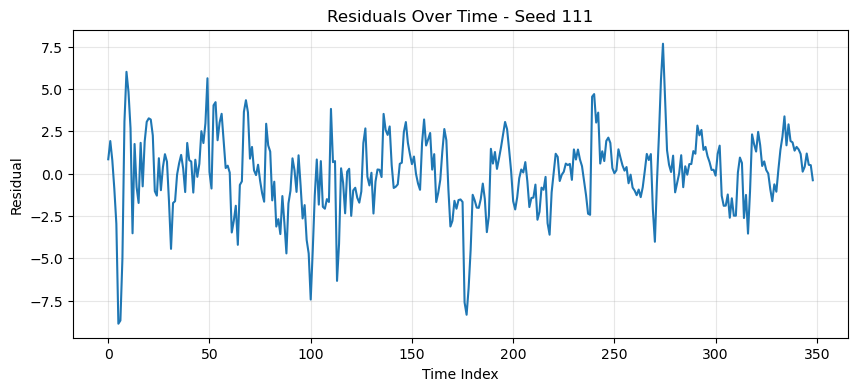

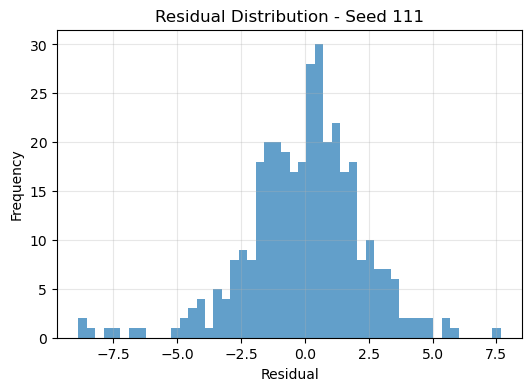

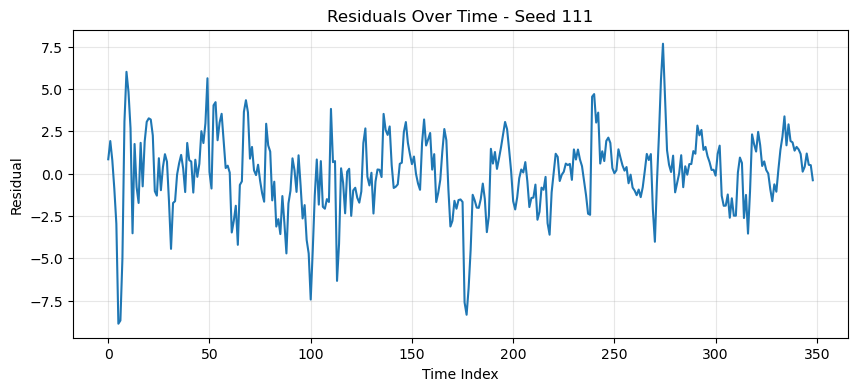

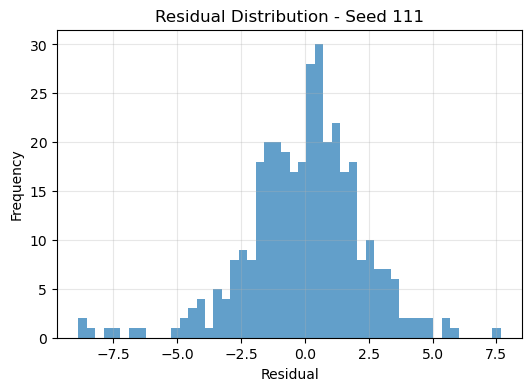

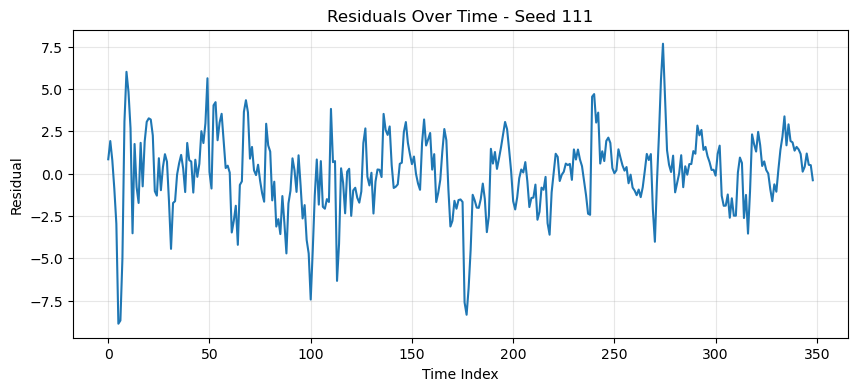

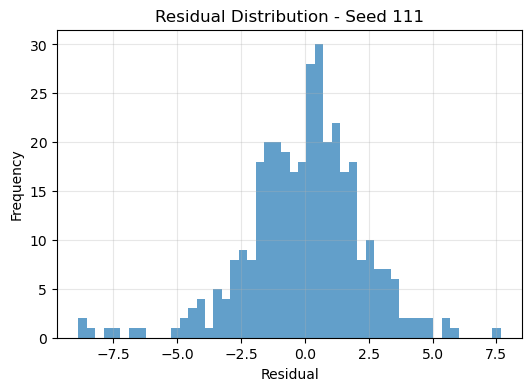

In [40]:
### >>  Residual Plot and Histrogram >> Loop through all predictions (3 seeds)
for i, pred in enumerate(predictions):
    residuals = pred["y_test"] - pred["y_pred"]
    
    # Residual over time
    plt.figure(figsize=(10,4))
    plt.plot(residuals, color="#1f77b4")
    plt.title(f"Residuals Over Time - Seed {pred['Seed']}")
    plt.xlabel("Time Index")
    plt.ylabel("Residual")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Residual histogram
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=50, alpha=0.7) #color="#ff7f0e", edgecolor="#ff7f0e"
    plt.title(f"Residual Distribution - Seed {pred['Seed']}")
    plt.xlabel("Residual")
    plt.ylabel("Frequency")
    plt.grid(True, alpha=0.3)
    plt.show()


#### Short Summary:  The result is identical so we only need to plot one 

In [21]:
predictions[0]

{'Run': 1,
 'Seed': 111,
 'y_test': array([115.959999, 117.160004, 116.5     , 115.010002, 112.650002,
        105.760002, 103.120003, 103.739998, 109.690002, 112.919998,
        113.290001, 112.760002, 107.720001, 112.339996, 110.370003,
        109.269997, 112.309998, 110.150002, 112.57    , 114.209999,
        115.309998, 116.279999, 116.410004, 113.919998, 113.449997,
        115.209999, 113.400002, 114.32    , 115.      , 114.709999,
        112.440002, 109.059998, 110.300003, 109.580002, 110.379997,
        110.779999, 111.309998, 110.779999, 109.5     , 112.120003,
        111.599998, 111.790001, 110.209999, 111.860001, 111.040001,
        111.730003, 113.769997, 113.760002, 115.5     , 119.080002,
        115.279999, 114.550003, 119.269997, 120.529999, 119.5     ,
        121.18    , 122.57    , 122.      , 120.919998, 121.059998,
        120.57    , 116.769997, 116.110001, 115.720001, 112.339996,
        114.18    , 113.690002, 117.290001, 118.779999, 119.300003,
        117.7

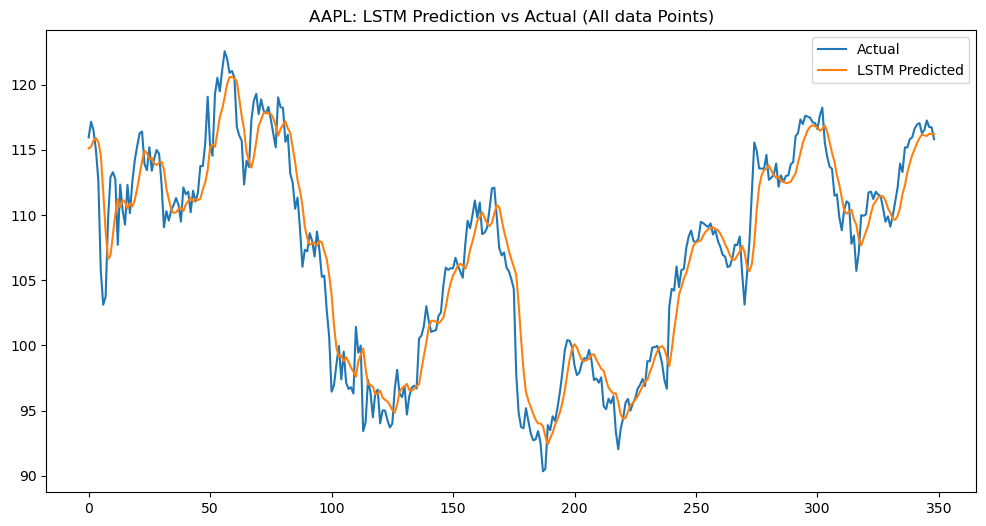

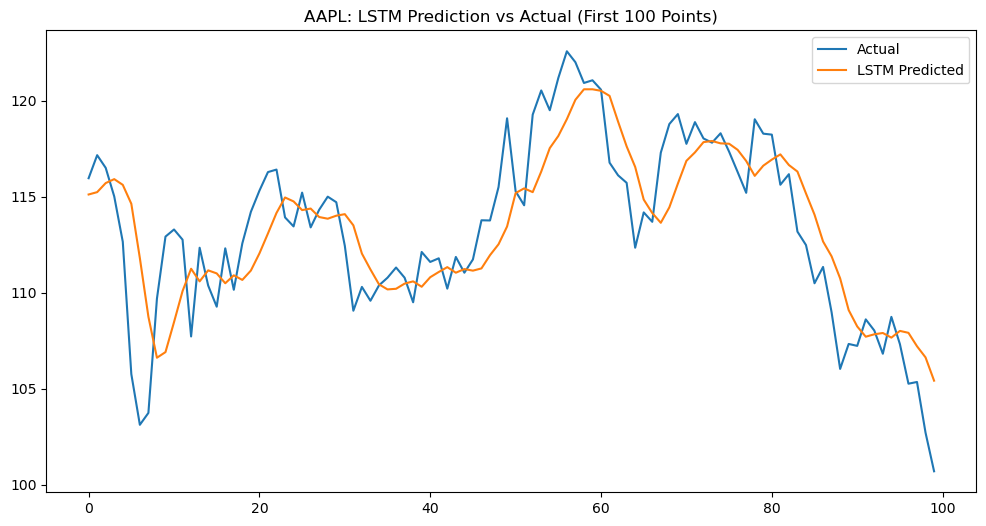

In [ ]:
### >> Quick prediction vs actual 

## Plot the last run

# matplot every data point for the prediction
plt.figure(figsize=(12,6))
plt.plot(y_test_inv[:], label="Actual")
plt.plot(y_pred_inv[:], label="LSTM Predicted")
plt.legend()
plt.title(f"{Tick}: LSTM Prediction vs Actual (All data Points)")
plt.show()


# first 100 data point 
plt.figure(figsize=(12,6))
plt.plot(y_test_inv[:100], label="Actual")
plt.plot(y_pred_inv[:100], label="LSTM Predicted")
plt.legend()
plt.title(f"{Tick}: LSTM Prediction vs Actual (First 100 Points)")
plt.show()


#### Prediction

In [46]:
residuals

array([ 8.47015296e-01,  1.92480503e+00,  7.92373657e-01, -9.02038710e-01,
       -2.96440077e+00, -8.86911787e+00, -8.68024419e+00, -5.00730882e+00,
        3.07694963e+00,  6.01476271e+00,  4.82275399e+00,  2.67789446e+00,
       -3.52603171e+00,  1.75073208e+00, -7.92182669e-01, -1.73348963e+00,
        1.81893202e+00, -7.53562453e-01,  1.90563232e+00,  3.05789176e+00,
        3.26656386e+00,  3.19584678e+00,  2.25718723e+00, -1.03716295e+00,
       -1.30216975e+00,  9.10262977e-01, -9.79774001e-01,  3.81111450e-01,
        1.14845276e+00,  7.01866065e-01, -1.64853712e+00, -4.44630388e+00,
       -1.73604589e+00, -1.62946303e+00, -5.53591401e-02,  6.09894020e-01,
        1.10730025e+00,  3.08449012e-01, -1.08930969e+00,  1.81197383e+00,
        7.95356276e-01,  7.12837304e-01, -1.12026986e+00,  8.20274743e-01,
       -1.89735328e-01,  5.82915903e-01,  2.50635564e+00,  1.80719743e+00,
        2.97936249e+00,  5.63347643e+00,  9.27278818e-02, -8.81584219e-01,
        4.03454626e+00,  

In [48]:
##### >>> 5. Prediction and Final Plot 

all_dates = df.index

# dates corresponding to y
look_back = 20
dates_y = all_dates[look_back:]  # start from day 21

# split dates into train and test
dates_train = dates_y[:split]
dates_test = dates_y[split:]

results = pd.DataFrame({
    "Date": dates_test,
    "Actual": y_test_inv.flatten(),
    "Predicted": y_pred_inv.flatten(),
    "Residuals": residuals
})







# ### >> Consolidate data
# all_dates = df.index

# # dates corresponding to y
# look_back = 20
# dates_y = all_dates[look_back:]  # start from day 21

# # split dates into train and test
# dates_train = dates_y[:split]
# dates_test = dates_y[split:]
# results_all = pd.DataFrame({"Date": dates_test, "Actual": predictions[0]["y_test"]})

# # Add all prediction columns
# for i, pred in enumerate(predictions):
#     results_all[f"Pred{i+1}"] = pred["y_pred"]

# # Convert to long format
# results_long = results_all.melt(
#     id_vars='Date',
#     value_vars=['Actual', 'Pred1', 'Pred2', 'Pred3'],
#     var_name='Type',
#     value_name='Price'
# )

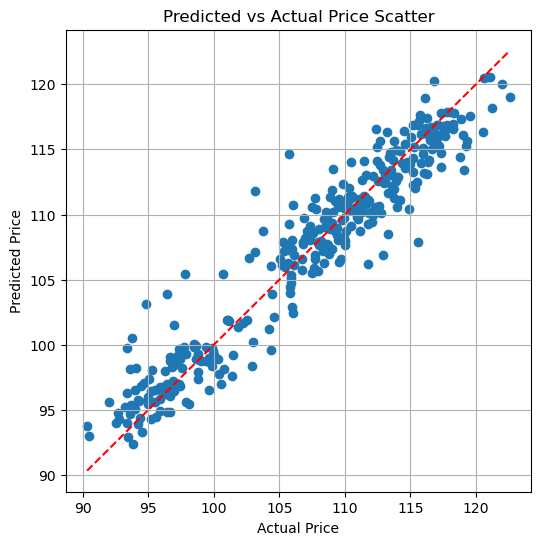

In [49]:
## >> Predicted vs Actual 
plt.figure(figsize=(6,6))
plt.scatter(results["Actual"], results["Predicted"])
plt.plot([results["Actual"].min(), results["Actual"].max()],
         [results["Actual"].min(), results["Actual"].max()],
         color='red', linestyle='--')  # perfect prediction line
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Price Scatter")
plt.grid(True)
plt.show()


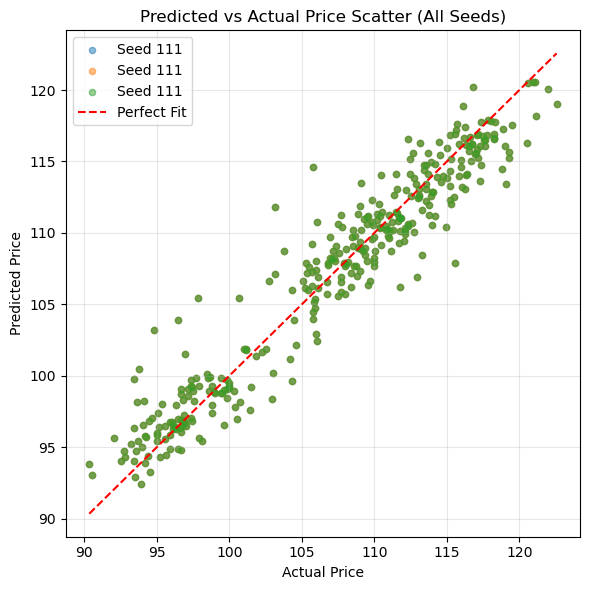

In [50]:
### Residual plot that compare three difference random run =- overlay

plt.figure(figsize=(6,6))

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

for i, pred in enumerate(predictions):
    plt.scatter(
        pred["y_test"],
        pred["y_pred"],
        alpha=0.5,
        s=20,
        color=colors[i],
        label=f"Seed {pred['Seed']}"
    )

# perfect prediction line
min_val = min([pred["y_test"].min() for pred in predictions])
max_val = max([pred["y_test"].max() for pred in predictions])
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="Perfect Fit")

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Actual Price Scatter (All Seeds)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


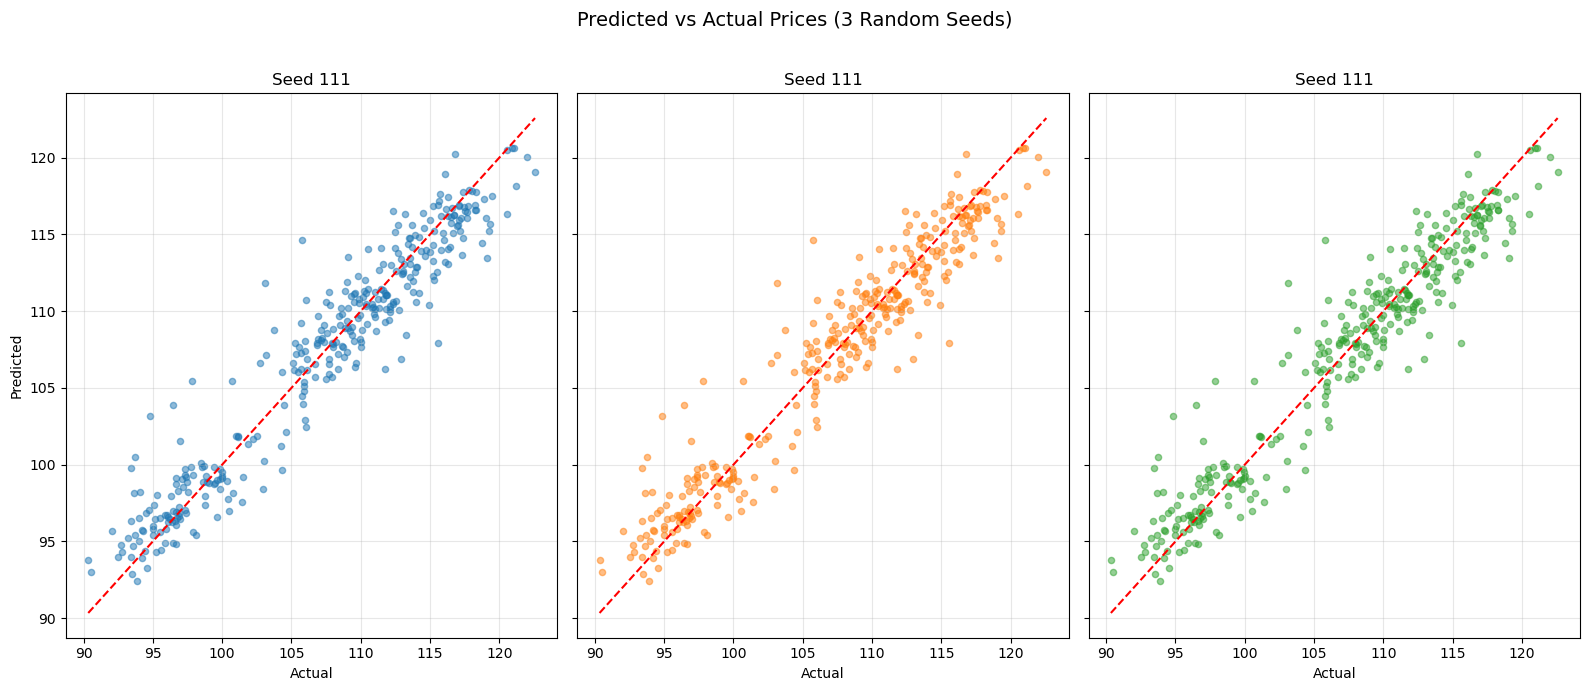

In [51]:
### Residual plot that compare three difference random run one panel per seed 

fig, axes = plt.subplots(1, 3, figsize=(16,7), sharex=True, sharey=True)
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

for i, pred in enumerate(predictions):
    ax = axes[i]
    ax.scatter(pred["y_test"], pred["y_pred"], alpha=0.5, s=20, color=colors[i])
    ax.plot(
        [pred["y_test"].min(), pred["y_test"].max()],
        [pred["y_test"].min(), pred["y_test"].max()],
        color='red', linestyle='--'
    )
    ax.set_title(f"Seed {pred['Seed']}")
    ax.set_xlabel("Actual")
    if i == 0:
        ax.set_ylabel("Predicted")
    ax.grid(True, alpha=0.3)

plt.suptitle("Predicted vs Actual Prices (3 Random Seeds)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [54]:
import plotly.express as px

fig = px.line(
    results.reset_index(),
    x='Date',
    y=['Actual', 'Predicted'],
    labels={'value': 'Price', 'Date': 'Date'},
    title="Actual vs Predicted Prices",
    template='plotly_white',
    color_discrete_map={'Actual':'#4C72B0', 'Predicted':'#DD8452'}  # soft colors
)

# Parameters you can change
background_color = "#E0E0E0"   # figure background
plot_bgcolor = "#E0E0E0"        # plot area background
grid_color = "#AAAAAA"          # grid line color
grid_width = 1                  # grid line thickness

fig.update_traces(mode='lines+markers')
fig.update_layout(
    width=1200,
    height=600,
    title_font_size=20,
    xaxis_title_font_size=16,
    yaxis_title_font_size=16,
    legend_title_font_size=14,
    plot_bgcolor=plot_bgcolor,        # plot area background
    paper_bgcolor=background_color,   # figure background
    margin=dict(l=50, r=50, t=60, b=50)
)

fig.update_xaxes(
    tickfont=dict(size=14),
    gridcolor=grid_color,
    gridwidth=grid_width
)

fig.update_yaxes(
    tickfont=dict(size=14),
    gridcolor=grid_color,
    gridwidth=grid_width
)
fig.show()

In [55]:
## >>> prediction function

def predict_next_day(last_20_days, model, scaler):
    """
    last_20_days: list or 1D array of the last 20 closing prices
    model: trained LSTM model
    scaler: fitted scaler used on training data
    """
    # Convert to numpy array and reshape to (1, look_back, 1)
    input_seq = np.array(last_20_days).reshape(1, len(last_20_days), 1)
    
    # Scale input using the same scaler
    input_scaled = scaler.transform(input_seq.reshape(-1,1)).reshape(1, len(last_20_days), 1)
    
    # Predict
    pred_scaled = model.predict(input_scaled)
    
    # Inverse scale to original price
    pred_price = scaler.inverse_transform(pred_scaled)[0,0]
    
    return pred_price


In [56]:
# Example: last 20 days closing prices
last_20_days = [100.5, 101.2, 102.1, 101.8, 102.5, 103.0, 102.8, 103.5,
                104.0, 104.2, 104.5, 105.0, 105.2, 105.5, 106.0, 106.2,
                106.5, 106.8, 107.0, 107.5]

predicted_price = predict_next_day(last_20_days, model_lstm, scaler)

print(f"Predicted next-day price: {predicted_price:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Predicted next-day price: 106.97


/home/yikai/miniconda3/envs/dsi_participant/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



In [ ]:
##### >>> Save Model

# model_lstm.save("aapl_lstm_model.h5")

# # Load in another script
# from tensorflow.keras.models import load_model
# model = load_model("aapl_lstm_model.h5")
